In [103]:
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import scipy.special
import matplotlib.pyplot
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pickle
import dlib
%matplotlib inline 

In [81]:
mypath_with_mask = r'C:\Users\Admin\with_mask\*'
mypath_without_mask = r'C:\Users\Admin\without_mask\*' 
images_with_mask = [cv2.imread(file, cv2.COLOR_BGR2GRAY) for file in glob.glob(mypath_with_mask)]
images_without_mask = [cv2.imread(file, cv2.COLOR_BGR2GRAY) for file in glob.glob(mypath_without_mask)]

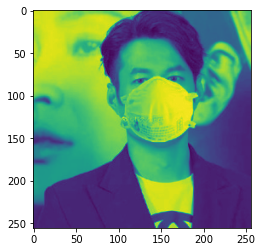

In [82]:
img = cv2.cvtColor(images_with_mask[1], cv2.COLOR_BGR2GRAY)
plt.imshow(img)

In [83]:
data_without_mask = []
data_with_mask = []
haar_data = cv2.CascadeClassifier('data.xml')
for i in range(len(images_without_mask)):
    faces = haar_data.detectMultiScale(images_without_mask[i])
    for x, y, w, h in faces:
        face = images_without_mask[i][y:y+h, x:x+w, :]
        face = cv2.resize(face, (50, 50))
        face  = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        data_without_mask.append(face)
    faces = haar_data.detectMultiScale(images_with_mask[i], 1.1, 4)
    for x, y, w, h in faces:
        face = images_with_mask[i][y:y+h, x:x+w, :]
        face = cv2.resize(face, (50, 50))
        face  = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        data_with_mask.append(face)

In [84]:
data = np.concatenate((data_without_mask[:len(data_with_mask)],data_with_mask),axis=0)
data = np.array(data).reshape(len(data), 50 * 50 )
print(data.shape)
target = np.array(([0] * len(data_with_mask)) + ([1] * len(data_with_mask))) 

(2738, 2500)


In [85]:
print(f"Форма массива даних: {data.shape}")
print(f"Форма массива вихідних даних: {target.shape}")


Форма массива даних: (2738, 2500)
Форма массива вихідних даних: (2738,)


In [86]:
data  = [(np.asfarray(data[i].tolist()) / 255.0 * 0.99) + 0.01 for i in range(len(data))] 
# data = [i.tolist() for i in data]
# print(data)

In [87]:
mask = {0 : "No Mask", 1 : "Mask"}

In [99]:
from sklearn.ensemble import RandomForestClassifier
X, y = data, target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
 random_state=42)
forest = RandomForestClassifier(n_estimators= 421, random_state=2)
forest.fit(X_train, y_train)
print("Правильність тестового набору: {:.3f}".format(forest.score(X_test, y_test)))

Правильність тестового набору: 0.901


In [105]:
with open('model.pkl','wb') as f:
    pickle.dump(forest,f)

In [101]:
capture = cv2.VideoCapture(0)
while True:
    flag, img = capture.read()
    if flag:
        img = cv2.flip(img, 90)
        faces = haar_data.detectMultiScale(img)
        for x, y, w, h in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 4)
            face = img[y:y+h, x:x+w, :]
            face = cv2.resize(face, (50, 50))
            face  = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face = np.array(face).reshape(50 * 50 )
            inputs = [(np.asfarray(face.tolist()) / 255.0 * 0.99) + 0.01]
            prediction = forest.predict(inputs)
            img = cv2.putText(img, mask[prediction[0]], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))
        cv2.imshow("result", img)
        if cv2.waitKey(2) == 27:
            break
    else:
        break
capture.release()
cv2.destroyAllWindows()